In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [1]:
# import libraries
!pip install opencv-python
import sklearn
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, kendalltau
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,fbeta_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading dataset

In [2]:
dataset_path='/content/drive/MyDrive/anemia-detection-main/database_sclere/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

# load csv file
df = pd.read_csv(dataset_path+'hbvalue.csv', sep=';')

# cut the dataset only to ind and ita dataset
df = df[(df['dataset']=='ind') | (df['dataset']=='ita')]

# Save the emoglobina values
df5coloumn = (df.iloc[:, 4])
emoglobina_strings = df5coloumn.to_numpy()
emoglobina_values = np.array([float(obj.replace(',', '.')) for obj in emoglobina_strings])

df.head()


,dataset,paziente,foto1,foto2,hb,Nome Cognome,Sesso,Et?,Data Nascita,buona,Unnamed: 10
0,ita,T_1,92317,92247,"14,1",Caterina Antonacci,F,40,1979.0,NaN,NaN
1,ita,T_2,93707,93702,"13,9",Maria Campobasso,F,34,1985.0,NaN,NaN
2,ita,T_3,94015,94012,"14,1",Vitangelo Lops,M,53,1966.0,NaN,NaN
3,ita,T_4,95329,95326,"15,7",Maro Mahdal,M,36,1983.0,NaN,NaN
4,ita,T_5,74439,74432,"13,9",Giuseppe Rosario Barile,M,51,1968.0,NaN,NaN


# Inizialization lists

In [3]:

#BGR
vessels_density = []

value_r_minous_g_img_sclera = []
value_r_minous_g_img_vessels = []

sclera_quantiles_bgr = []
vessels_quantiles_bgr = []

dev_std_sclera = []
dev_std_vessels = []

#Lab
vessels_density_lab = []

value_a_img_sclera = []
value_a_img_vessels = []

sclera_quantiles_lab = []
vessels_quantiles_lab = []

dev_std_sclera_cielab = []
dev_std_vessels_cielab = []

vessels_colors_white_deviations_cielab = []
vessels_colors_white_quantiles_cielab = []

# Loading italian (1/2) photos

In [4]:
sclera_vessels = []
sclera_masks = []

# cicla sul dataset indiano
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    path_photos = dataset_path+'Italiano congiuntive/Dataset congiuntive italiano segmentato 1/'
    paziente = row['paziente'] + "_"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)

            sclera_vessels.append(sclera_vessel)
            break


100%|██████████| 186/186 [00:20<00:00,  9.03it/s] 


# Loading italian (2/2) photos

In [5]:
# cicla sul dataset indiano
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    path_photos = dataset_path+'Italiano congiuntive/Dataset congiuntive italiano segmentato 2/'
    paziente = row['paziente'] + "_"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)


            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)

            sclera_vessels.append(sclera_vessel)
            break


100%|██████████| 186/186 [00:20<00:00,  8.99it/s]


# Loading indian (1/2) photos

In [13]:
sclera_vessels = []
sclera_masks = []

# cicla sul dataset indiano
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    path_photos = dataset_path+'Dataset indiano 1/'
    paziente = row['paziente'] + "-"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)

            sclera_vessels.append(sclera_vessel)
            break


100%|██████████| 186/186 [00:10<00:00, 17.04it/s]


# Loading indian (2/2) photos

In [14]:
# cicla sul dataset indiano
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    path_photos = dataset_path+'Dataset indiano 2/'
    paziente = row['paziente'] + "-"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)

            sclera_vessels.append(sclera_vessel)
            break


100%|██████████| 186/186 [00:14<00:00, 12.69it/s]


# Preprocessing

100%|██████████| 95/95 [00:00<00:00, 589.06it/s]


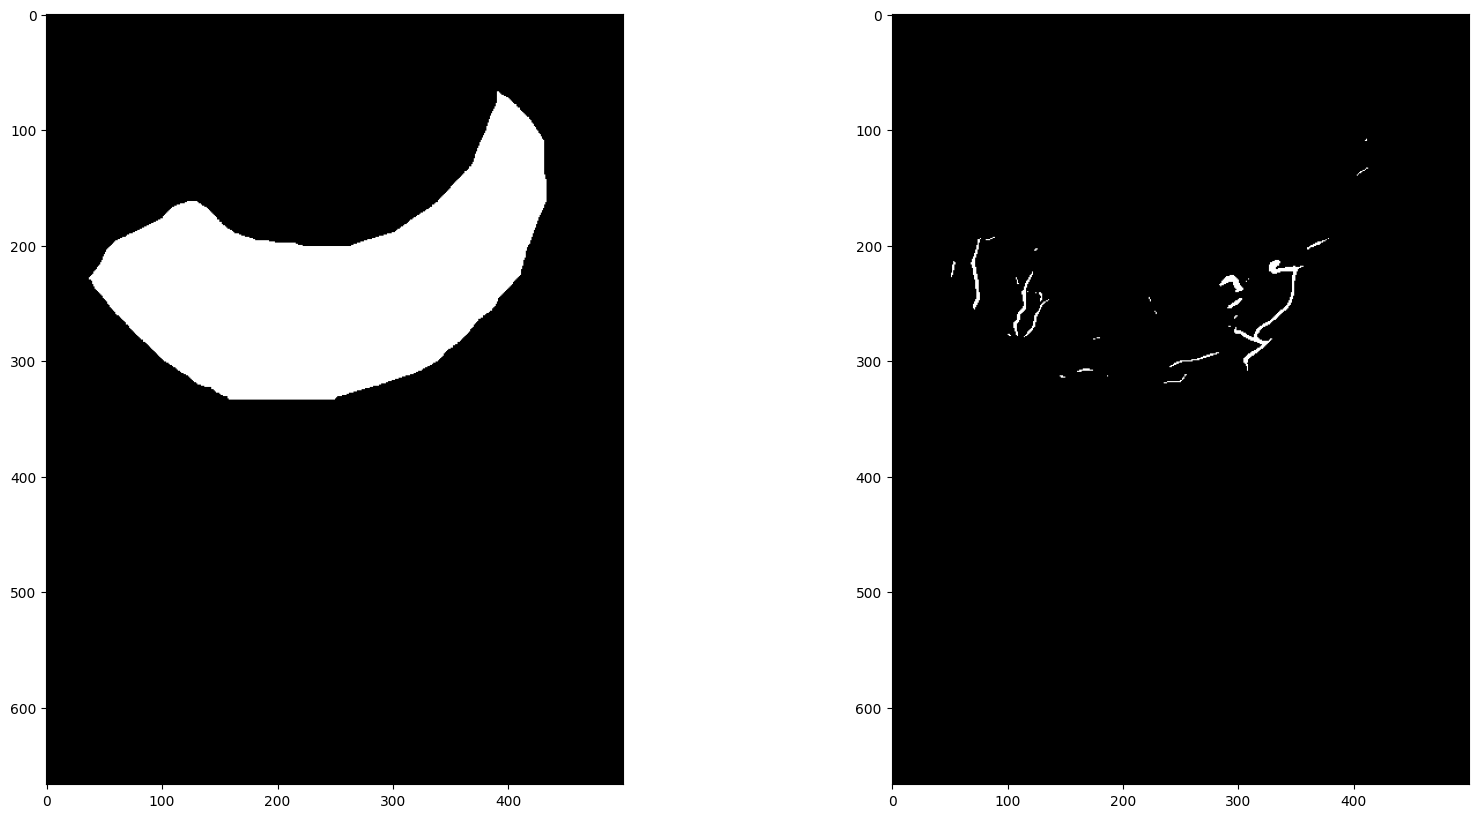

In [15]:
sclera_vessels_shape = sclera_vessels[0].shape
sclera_masks_bw = []                                # array of black and white sclera
sclera_vessels_bw = []                              # array of black and white sclera vessels

# converts the sclera masks to black and white
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    # resize the mask to the sclera vessel shape
    mask = cv2.resize(mask, sclera_vessels_shape[:2][::-1])

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_masks_bw.append(mask)

# converts the sclera vessels to black and white
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
    # transparence becomes black
    mask[mask[:, :, 3] == 0] = [0, 0, 0, 0]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_vessels_bw.append(mask)

# show the sclera masks and sclera vessels
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_masks_bw[1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_bw[1], cmap='gray')
plt.show()

# Mask application

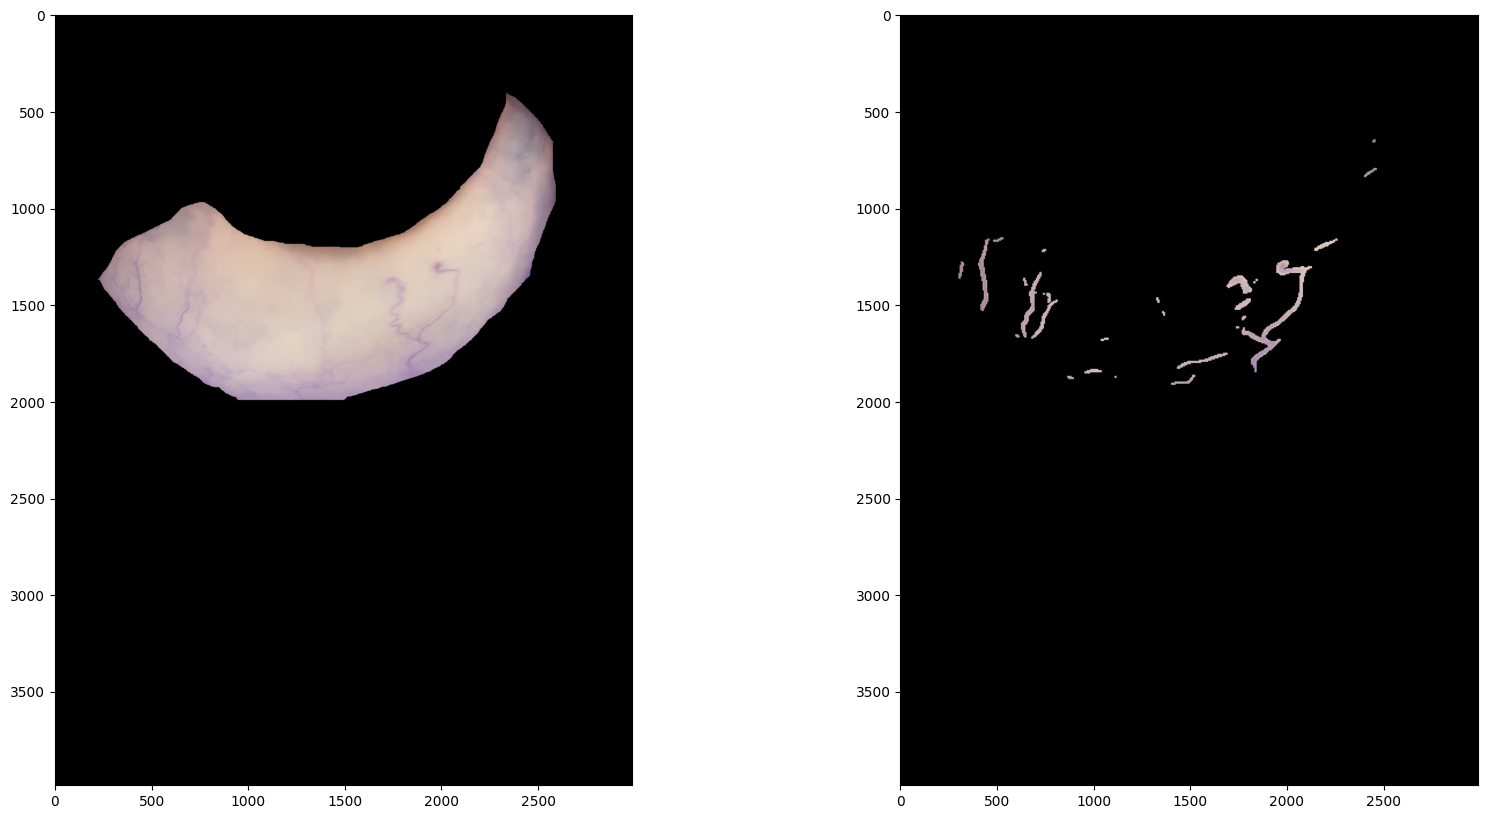

In [16]:
# sclera_masks = []                                # array of coulored sclera

# sclera_masks_bw = []                                # array of black and white sclera
# sclera_vessels_bw = []                                # array of black and white sclera vessels

sclera_masked = []                                    # array of sclera with only sclera part is coloured
sclera_vessels_masked = []                            # array of sclera with only sclera part is coloured


np.save("sclera_masks.npy", sclera_masks)
np.save("sclera_masks_bw.npy", sclera_masks_bw)
np.save("sclera_vessels.npy", sclera_vessels)
np.save("sclera_vessels_bw.npy", sclera_vessels_bw)

for l in range (len(sclera_masks_bw)):
    sclera_masked.append(sclera_masks[l])
    sclera_masks_bw[l] =  cv2.resize(sclera_masks_bw[l], sclera_masked[l].shape[:2][::-1])
    sclera_masked[l] = cv2.bitwise_and(sclera_masked[l], sclera_masked[l], mask=sclera_masks_bw[l])                  # Se il pixel della maschera è nero

# elimina lista maschere
del sclera_masks_bw
del sclera_vessels

for l in range (len(sclera_vessels_bw)):
    sclera_vessels_masked.append(sclera_masks[l])
    sclera_vessels_bw[l] =  cv2.resize(sclera_vessels_bw[l], sclera_vessels_masked[l].shape[:2][::-1])
    sclera_vessels_masked[l] = cv2.bitwise_and(sclera_vessels_masked[l], sclera_vessels_masked[l], mask=sclera_vessels_bw[l])                  # Se il pixel della maschera è nero

del sclera_vessels_bw
del sclera_masks

# Visualizza l'immagine risultante
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_masked[1])
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_masked[1])
plt.show()


# Metrics calculation (BGR)

In [17]:

# sclera_masked
# sclera_vessels_masked

# calculate the metrics
number_sclera_pixel = 0
number_vessels_pixel = 0
number_sclera_pixel_coulored = 0
number_vessels_pixel_coulored = 0

b = 0
g = 0
r = 0

value_r_minous_g_pixel_sclera = 0
value_r_minous_g_pixel_vessels = 0


for l in range(len(sclera_masked)):                               # Per ogni immagine della sclera
    number_sclera_pixel = 0
    number_vessels_pixel = 0
    value_r_minous_g_pixel_sclera = 0
    value_r_minous_g_pixel_vessels = 0


    #Conta pixel colorati
    img_gray = cv2.cvtColor(sclera_masked[l], cv2.COLOR_BGR2GRAY)
    _, img_binaria = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    number_sclera_pixel_coulored = cv2.countNonZero(img_binaria)

    #Conta pixel totali
    number_sclera_pixel = img_binaria.size

    # Calcola la differenza tra il canale rosso e il canale verde
    b, g, r = cv2.split(sclera_masked[l])
    value_r_minous_g_pixel_sclera = np.sum(r/10) - np.sum(g/10)

    std_sclera = cv2.meanStdDev(r-g)[1]

    # Inizializzazione quantili sclera
    quantile = np.empty((3, 3))
    filtered_bgr = sclera_masked[l][:, :, 0]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]
    # calcola i quantili
    quantile[0] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_masked[l][:, :, 1]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]
    # calcola i quantili
    quantile[1] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_masked[l][:, :, 2]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]
    # calcola i quantili
    quantile[2] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])
    sclera_quantiles_bgr.append(quantile)

    #Conta pixel colorati
    img_gray = cv2.cvtColor(sclera_vessels_masked[l], cv2.COLOR_BGR2GRAY)
    _, img_binaria = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    number_vessels_pixel_coulored = cv2.countNonZero(img_binaria)

    #Conta pixel totali
    number_vessels_pixel = img_binaria.size

    # Calcola la differenza tra il canale rosso e il canale verde
    b, g, r = cv2.split(sclera_vessels_masked[l])
    value_r_minous_g_pixel_vessels = np.sum(r/10) - np.sum(g/10)

    std_vessels = cv2.meanStdDev(r-g)[1]

    # Inizializzazione quantili sclera
    quantile = np.empty((3, 3))
    filtered_bgr = sclera_vessels_masked[l][:, :, 0]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]
    # calcola i quantili
    quantile[0] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_vessels_masked[l][:, :, 1]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]
    # calcola i quantili
    quantile[1] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_vessels_masked[l][:, :, 2]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]
    # calcola i quantili
    quantile[2] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])
    vessels_quantiles_bgr.append(quantile)

    vessels_density.append(number_vessels_pixel_coulored/number_sclera_pixel_coulored)
    #print("il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la", l+1, "° immagine è: ", vessels_density[l])
    value_r_minous_g_img_sclera.append(value_r_minous_g_pixel_sclera/number_sclera_pixel)
    #print("il valore medio dei pixel della sclera, calcolati come R - G, per la", l+1, "° immagine è: ",value_r_minous_g_img_sclera[l])
    value_r_minous_g_img_vessels.append(value_r_minous_g_pixel_vessels/number_vessels_pixel)
    #print("il valore medio dei pixel dei vasi, calcolati come R - G, per la", l+1, "° immagine è: ", value_r_minous_g_img_vessels[l])

    dev_std_sclera.append(std_sclera)
    dev_std_vessels.append(std_vessels)

    #print("i quantili della sclera", l+1, "° sono:\n", sclera_quantiles_bgr[l])
    #print("i quantili dei vasi", l+1, "° sono:\n", vessels_quantiles_bgr[l])



# Conversion and contrast lab

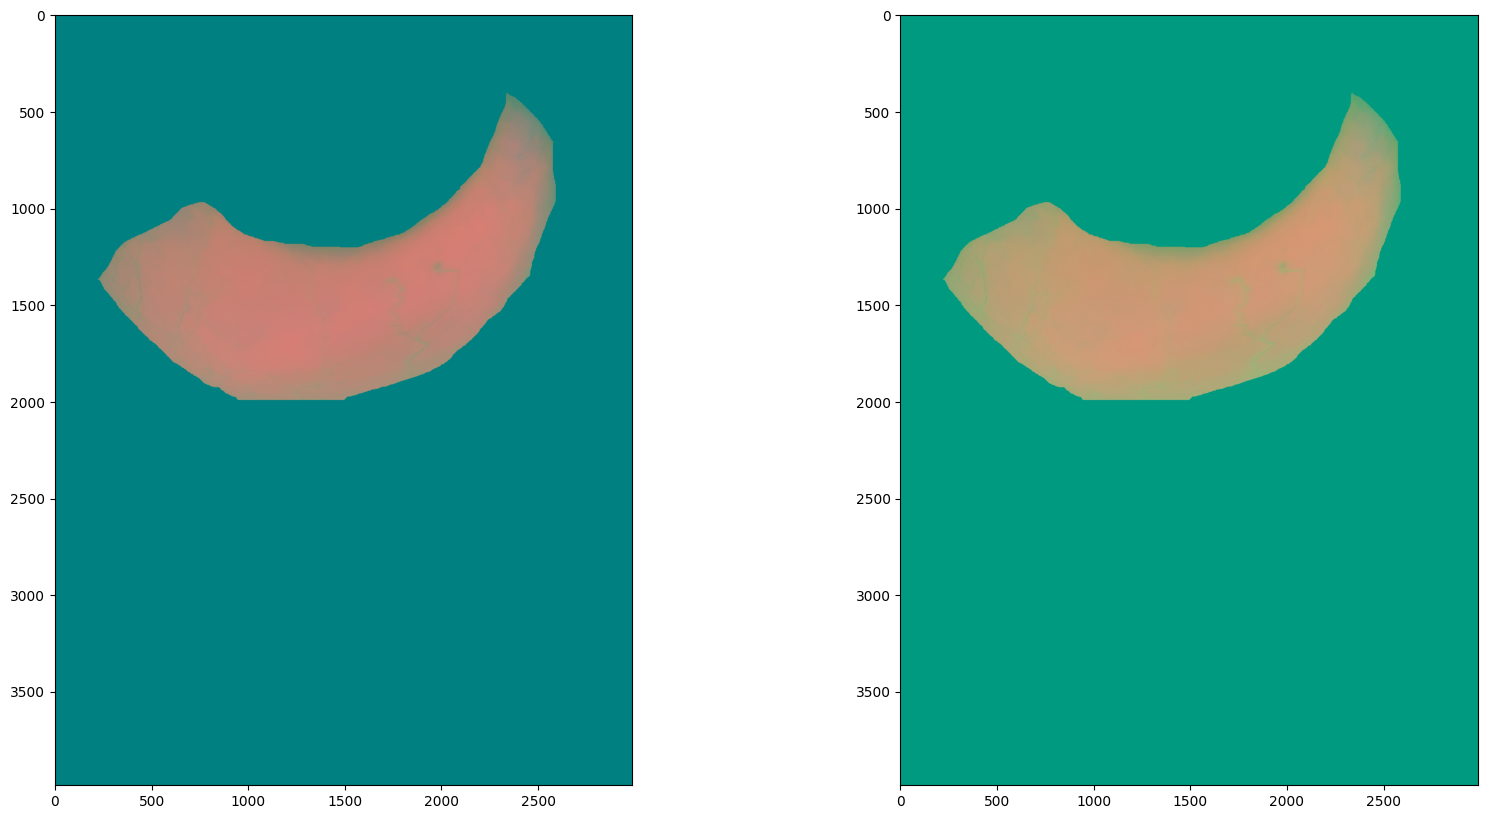

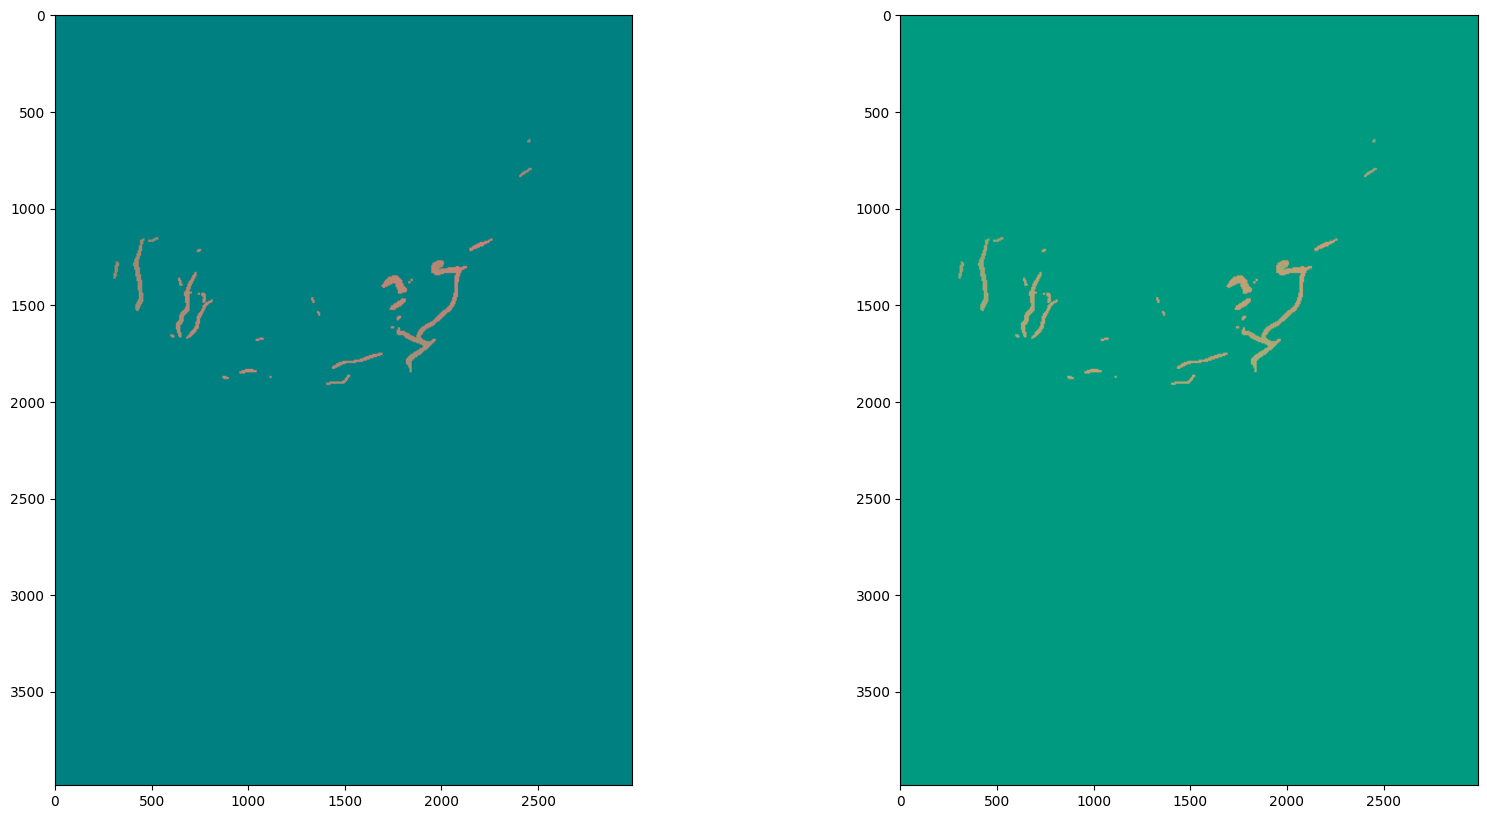

In [18]:
sclera_lab = []
sclera_vessels_lab = []

# Converti le sclere in formato Lab
sclera_es = cv2.cvtColor(sclera_masked[1], cv2.COLOR_BGR2LAB)       #img per esempio
for i in range(len(sclera_masked)):

  # Converto --> aumento il contrasto --> riempio la lista
  img_lab = cv2.cvtColor(sclera_masked[i], cv2.COLOR_BGR2LAB)
  img_lab[:, :, 1] = cv2.multiply(img_lab[:, :, 1], 1.2)
  sclera_lab.append(img_lab)


del sclera_masked

# Visualizza l'immagine originale e l'immagine con il contrasto aumentato per un solo esempio
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_lab[1])
plt.show()

# Converto i vasi in cielab
vessel_es = cv2.cvtColor(sclera_vessels_masked[1], cv2.COLOR_BGR2LAB)       #img per esempio
for i in range(len(sclera_vessels_masked)):

  # Converto --> aumento il contrasto --> riempio la lista
  img_lab = cv2.cvtColor(sclera_vessels_masked[i], cv2.COLOR_BGR2LAB)
  img_lab[:, :, 1] = cv2.multiply(img_lab[:, :, 1], 1.2)
  sclera_vessels_lab.append(img_lab)

# Libera spazio in memoria
del sclera_vessels_masked

# Visualizza l'immagine originale e l'immagine con il contrasto aumentato per un solo esempio
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(vessel_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_lab[1])
plt.show()


# Converision lab, contrast e clahe

In [17]:
sclera_lab = []
sclera_vessels_lab = []

# Converti le sclere in formato Lab
sclera_es = cv2.cvtColor(sclera_masked[1], cv2.COLOR_BGR2LAB)       #img per esempio
for l in range(len(sclera_masked)):

  # Converto --> aumento il contrasto --> riempio la lista
  img_lab = cv2.cvtColor(sclera_masked[l], cv2.COLOR_BGR2LAB)

  # Applica l'equalizzazione dell'istogramma adattivo a tutti i canali (L, a, b) dell'immagine Lab
  clahe = cv2.createCLAHE(clipLimit=1.82, tileGridSize=(8, 8))
  image_lab_eq = img_lab.copy()
  for i in range(3):
    image_lab_eq[:, :, i] = clahe.apply(image_lab_eq[:, :, i])

  # Applica il contrasto all'immagine Lab
  image_lab_eq[:, :, 1] = cv2.multiply(image_lab_eq[:, :, 1], 1.2)
  image_lab_eq = image_lab_eq[:, :, 1]

  sclera_lab.append(image_lab_eq)


#del sclera_masked

# Visualizza l'immagine originale e l'immagine con il contrasto aumentato per un solo esempio
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_lab[1])
plt.show()

# Converto i vasi in cielab
vessel_es = cv2.cvtColor(sclera_vessels_masked[1], cv2.COLOR_BGR2LAB)       #img per esempio
for l in range(len(sclera_vessels_masked)):

  # Converto --> aumento il contrasto --> riempio la lista
  img_lab = cv2.cvtColor(sclera_vessels_masked[l], cv2.COLOR_BGR2LAB)

  # Applica l'equalizzazione dell'istogramma adattivo a tutti i canali (L, a, b) dell'immagine Lab
  clahe = cv2.createCLAHE(clipLimit=1.82, tileGridSize=(8, 8))
  image_lab_eq = img_lab.copy()
  for i in range(3):
    image_lab_eq[:, :, i] = clahe.apply(image_lab_eq[:, :, i])

  # Applica il contrasto all'immagine Lab
  image_lab_eq[:, :, 1] = cv2.multiply(image_lab_eq[:, :, 1], 1.2)
  image_lab_eq = image_lab_eq[:, :, 1]

  sclera_vessels_lab.append(image_lab_eq)

# Libera spazio in memoria
#del sclera_vessels_masked

# Visualizza l'immagine originale e l'immagine con il contrasto aumentato per un solo esempio
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(vessel_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_lab[1])
plt.show()


KeyboardInterrupt: ignored


# Metrics calculation (Lab)

In [19]:
# Calculate the metrics
number_sclera_pixel = 0
number_vessels_pixel = 0
number_sclera_pixel_coulored = 0
number_vessels_pixel_coulored = 0

L = 0
a = 0
b = 0

value_a_pixel_sclera = 0
value_a_pixel_vessels = 0


for l in range (len(sclera_lab)):                               # Per ogni immagine della sclera
    number_sclera_pixel = 0
    number_vessels_pixel = 0
    value_a_pixel_sclera = 0
    value_a_pixel_vessels = 0


    #Conta pixel totali
    number_sclera_pixel = img_binaria.size

    # Calcola la differenza tra il canale rosso e il canale verde
    L, a, b = cv2.split(sclera_lab[l])
    value_a_pixel_sclera = np.sum(a/10)

    std_sclera = cv2.meanStdDev(a)[1]

    # Inizializzazione quantili sclera
    quantile = np.empty((3, 3))
    filtered_lab = sclera_lab[l][:, :, 0]
    filtered_lab = filtered_lab[filtered_lab != 0]
    # calcola i quantili
    quantile[0] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_lab[l][:, :, 1]
    filtered_lab = filtered_lab[filtered_lab != 154]
    # calcola i quantili
    quantile[1] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_lab[l][:, :, 2]
    filtered_lab = filtered_lab[filtered_lab != 128]
    # calcola i quantili
    quantile[2] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])
    sclera_quantiles_lab.append(quantile)


    #Conta pixel colorati
    lab_to_bgr = cv2.cvtColor(sclera_vessels_lab[l], cv2.COLOR_LAB2BGR)
    img_gray = cv2.cvtColor(lab_to_bgr, cv2.COLOR_BGR2GRAY)
    _, img_binaria = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    number_vessels_pixel_coulored = cv2.countNonZero(img_binaria)

    #Conta pixel totali
    number_vessels_pixel = img_binaria.size

    # Calcola la differenza tra il canale rosso e il canale verde
    L, a, b = cv2.split(sclera_vessels_lab[l])
    value_a_pixel_vessels = np.sum(a/10)

    std_vessels_L = cv2.meanStdDev(L)[1]
    std_vessels_b = cv2.meanStdDev(b)[1]

    # Inizializzazione quantili vasi
    quantile = np.empty((3, 3))
    filtered_lab = sclera_vessels_lab[l][:, :, 0]
    filtered_lab = filtered_lab[filtered_lab != 0]
    # calcola i quantili
    quantile[0] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_vessels_lab[l][:, :, 1]
    filtered_lab = filtered_lab[filtered_lab != 154]
    # calcola i quantili
    quantile[1] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_vessels_lab[l][:, :, 2]
    filtered_lab = filtered_lab[filtered_lab != 128]
    # calcola i quantili
    quantile[2] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])
    vessels_quantiles_lab.append(quantile)


    vessels_density_lab = vessels_density.copy()
    #print("il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la", l+1, "° immagine è: ", vessels_density[l])
    value_a_img_sclera.append(value_a_pixel_sclera/number_sclera_pixel)
    #print("il valore medio dei pixel della sclera, calcolati come a*, per la", l+1, "° immagine è: ",value_a_img_sclera[l])
    value_a_img_vessels.append(value_a_pixel_vessels/number_vessels_pixel)
    #print("il valore medio dei pixel dei vasi, calcolati come a*, per la", l+1, "° immagine è: ", value_a_img_vessels[l])

    dev_std_sclera_cielab.append(std_sclera)
    dev_std_vessels_cielab.append([std_vessels_L, std_vessels_b])


    #print("i quantili della sclera", l+1, "° sono:\n", sclera_quantiles_lab[l])
    #print("i quantili dei vasi", l+1, "° sono:\n", vessels_quantiles_lab[l])



del sclera_lab
del sclera_vessels_lab

# White of sclera

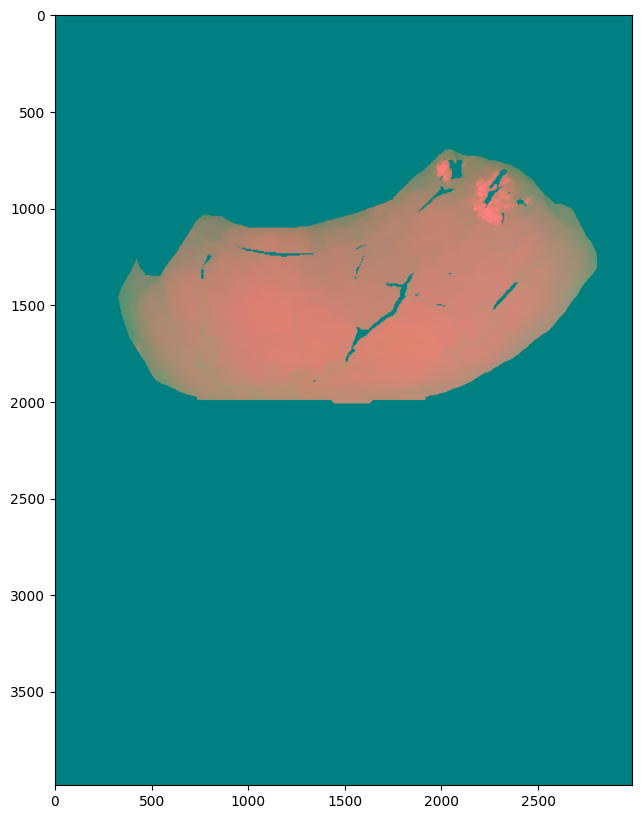

In [20]:
sclera_masks = np.load("sclera_masks.npy")
sclera_masks_bw = np.load("sclera_masks_bw.npy")
sclera_vessels = np.load("sclera_vessels.npy")
sclera_vessels_bw = np.load("sclera_vessels_bw.npy")

for l in range (len(sclera_masks)):


        sclera_vessels_bw[l] = cv2.bitwise_not(sclera_vessels_bw[l])
        maschera = cv2.bitwise_and(sclera_masks_bw[l], sclera_vessels_bw[l])
        maschera =  cv2.resize(maschera, sclera_masks[l].shape[:2][::-1])

        # metti in and la maschera con sclera_mask
        vessels_colors_white = cv2.bitwise_and(sclera_masks[l], sclera_masks[l], mask=maschera)
        vessels_colors_white = cv2.cvtColor(vessels_colors_white, cv2.COLOR_BGR2LAB)

        # calcolo la deviazione standard
        L, a, b = cv2.split(vessels_colors_white)
        std_vessels_color_white_L = cv2.meanStdDev(L)[1]
        std_vessels_color_white_b = cv2.meanStdDev(b)[1]

        vessels_colors_white_deviations_cielab.append([std_vessels_color_white_L, std_vessels_color_white_b])

        # Inizializzazione quantili vasi
        quantile = np.empty((3, 3))
        filtered_lab = vessels_colors_white[:, :, 0]
        filtered_lab = filtered_lab[filtered_lab != 0]
        # calcola i quantili
        quantile[0] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

        filtered_lab = vessels_colors_white[:, :, 1]
        filtered_lab = filtered_lab[filtered_lab != 154]
        # calcola i quantili
        quantile[1] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

        filtered_lab = vessels_colors_white[:, :, 2]
        filtered_lab = filtered_lab[filtered_lab != 128]
        # calcola i quantili
        quantile[2] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

        vessels_colors_white_quantiles_cielab.append(quantile)



plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(vessels_colors_white)
plt.show()

del sclera_masks
del sclera_masks_bw
del sclera_vessels
del sclera_vessels_bw

# Logistic regression

In [20]:
# importa naive bayes
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# prepara le features per il modello
X = []
# cicla sulle metriche (densità, quantili, deviazioni standard, ...) per ricavare le feature
for index, (
    color_density,
    color_quantiles,
    color_deviation,
    white_deviation_cielab,
    white_quantiles_cielab
) in tqdm(
    enumerate(zip(
        vessels_density_lab,
        vessels_quantiles_lab,
        dev_std_vessels_cielab,
        vessels_colors_white_deviations_cielab,
        vessels_colors_white_quantiles_cielab
    )),
    total=len(vessels_density_lab)
):
    # Feature light
    light_vessel = color_quantiles[0][1]                                        # mediana del canale L dei vasi sanguigni
    diff_light = white_quantiles_cielab[0][2] - color_quantiles[0][2]           # diff. tra i quantili 75 deo canale L
    diff_deviations_light = color_deviation[0] - white_deviation_cielab[0]      # diff. tra le deviaz. dei canali L

    # Feature red
    A_star = color_density                                                   # A_star dei vasi sanguigni
    diff_red = color_quantiles[1][2] - white_quantiles_cielab[1][2]             # diff. tra i quantili 75 del canale A*

    # Feature blue
    diff_blue = white_quantiles_cielab[2][0] - color_quantiles[2][2]            # diff. tra il quantile 25 del canale B della parte bianca e 75 dei vasi sanguigni
    diff_deviations_blue = color_deviation[1] - white_deviation_cielab[1]       # diff. tra le deviaz. del canale B

    # aggiungi le feature all'array X
    X.append([
        A_star, diff_red, # feature red
        light_vessel, diff_light, diff_deviations_light,  # feature light
        diff_blue, diff_deviations_blue,  # feature blue
    ])


# Costruisci l'array delle y
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # preleva il valore di emoglobina e lo converte in float
    hb = float(row['hb'].replace(',', '.'))

    # se hb è minore di 12.5 allora è anemico
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)

# train the model
clf = SVC(kernel='linear', C=1, random_state=0)

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(fbeta_score, beta=2))
print("f2: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())

100%|██████████| 186/186 [00:00<00:00, 5431.86it/s]


f1:  0.7115805733496887
f2:  0.7050694598532263
recall:  0.7197802197802198
precision:  0.7866666666666666
accuracy:  0.773968705547653
roc_auc:  0.8247431915910177


# SVC Linear

In [22]:

# prepara le features per il modello
X = []
# cicla sulle metriche (densità, quantili, deviazioni standard, ...) per ricavare le feature
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab
    )),
    total=len(vessels_density_lab)
):

    one = density
    two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera
    five = devstd_vessels
    six = sclera_quantile_bgr[2][2]
    seven = vessels_quantile_bgr[2][2]
    eight = a_img_sclera
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    #eleven = devstd_vessels_cielab[0][0]
    dodici = sclera_quantile_lab[2][2]
    #tredici = vessels_quantile_lab[2][2]

    # aggiungi le feature all'array X
    X.append([
        one,
        two,
        tree,
        four,
        five,
        six,
        seven,
        eight,
        nine,
        ten,
        dodici
    ])


# Costruisci l'array delle y
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # preleva il valore di emoglobina e lo converte in float
    hb = float(row['hb'].replace(',', '.'))

    # se hb è minore di 12.5 allora è anemico
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)

# train the model
clf = SVC(kernel='linear', C=1, random_state=0)

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(fbeta_score, beta=2))
print("f2: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())

100%|██████████| 186/186 [00:00<00:00, 14243.94it/s]


f1:  0.82039898989899
f2:  0.8267173423423424
recall:  0.8395604395604396
precision:  0.845959595959596
accuracy:  0.8603129445234708
roc_auc:  0.919628921802835


# KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier
# prepara le features per il modello
X = []
# cicla sulle metriche (densità, quantili, deviazioni standard, ...) per ricavare le feature
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab
    )),
    total=len(vessels_density_lab)
):

    one = density
    two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera
    five = devstd_vessels
    six = sclera_quantile_bgr[2][2]
    seven = vessels_quantile_bgr[2][2]
    eight = a_img_sclera
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    #eleven = devstd_vessels_cielab[0][0]
    dodici = sclera_quantile_lab[2][2]
    #tredici = vessels_quantile_lab[2][2]

    # aggiungi le feature all'array X
    X.append([
        one,
        two,
        tree,
        four,
        five,
        six,
        seven,
        eight,
        nine,
        ten,
        dodici,
    ])


# Costruisci l'array delle y
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # preleva il valore di emoglobina e lo converte in float
    hb = float(row['hb'].replace(',', '.'))

    # se hb è minore di 12.5 allora è anemico
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)

# Crea il classificatore Nearest Neighbor
clf = KNeighborsClassifier(n_neighbors=5)

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(fbeta_score, beta=2))
print("f2: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())

100%|██████████| 186/186 [00:00<00:00, 9307.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which 

f1:  0.7148663101604278
f2:  0.7273805703282598
recall:  0.7494505494505495
precision:  0.7403030303030305
accuracy:  0.7684210526315789
roc_auc:  0.8158066571110048


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

# Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
# prepara le features per il modello
X = []
# cicla sulle metriche (densità, quantili, deviazioni standard, ...) per ricavare le feature
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab
    )),
    total=len(vessels_density_lab)
):

    one = density
    two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera
    five = devstd_vessels
    six = sclera_quantile_bgr[2][2]
    seven = vessels_quantile_bgr[2][2]
    eight = a_img_sclera
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    #eleven = devstd_vessels_cielab[0][0]
    dodici = sclera_quantile_lab[2][2]
    #tredici = vessels_quantile_lab[2][2]

    # aggiungi le feature all'array X
    X.append([
        one,
        two,
        tree,
        four,
        five,
        six,
        seven,
        eight,
        nine,
        ten,
        dodici,
    ])


# Costruisci l'array delle y
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # preleva il valore di emoglobina e lo converte in float
    hb = float(row['hb'].replace(',', '.'))

    # se hb è minore di 12.5 allora è anemico
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)

# Creazione dell'istanza del classificatore
clf = RandomForestClassifier(n_estimators=75, random_state=0)

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(fbeta_score, beta=2))
print("f2: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())


100%|██████████| 186/186 [00:00<00:00, 9884.46it/s]


f1:  0.8130559006211181
f2:  0.8076647814551039
recall:  0.8098901098901099
precision:  0.8442857142857143
accuracy:  0.8549075391180654
roc_auc:  0.9047768354833572


# Adaboost

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# prepara le features per il modello
X = []
# cicla sulle metriche (densità, quantili, deviazioni standard, ...) per ricavare le feature
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab
    )),
    total=len(vessels_density_lab)
):

    one = density
    two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera
    five = devstd_vessels
    six = sclera_quantile_bgr[2][2]
    seven = vessels_quantile_bgr[2][2]
    eight = a_img_sclera
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    #eleven = devstd_vessels_cielab[0][0]
    dodici = sclera_quantile_lab[2][2]
    #tredici = vessels_quantile_lab[2][2]

    # aggiungi le feature all'array X
    X.append([
        one,
        two,
        tree,
        four,
        five,
        six,
        seven,
        eight,
        nine,
        ten,
        dodici,
    ])


# Costruisci l'array delle y
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # preleva il valore di emoglobina e lo converte in float
    hb = float(row['hb'].replace(',', '.'))

    # se hb è minore di 12.5 allora è anemico
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)

# Creazione dell'istanza del classificatore base (classificatore debole)
base_classifier = DecisionTreeClassifier(max_depth=1)

# Creazione dell'istanza del classificatore Adaboost
clf = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=5, random_state=0)

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(fbeta_score, beta=2))
print("f2: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())


100%|██████████| 186/186 [00:00<00:00, 8221.27it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray

f1:  0.7671575502571295
f2:  0.7610711034926678


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/pyt

recall:  0.7648351648351649
precision:  0.8080451574569221


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/pyt

accuracy:  0.8226173541963016
roc_auc:  0.8717918856505813


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


# SVC Polynomial

In [63]:

# prepara le features per il modello
X = []
# cicla sulle metriche (densità, quantili, deviazioni standard, ...) per ricavare le feature
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab
    )),
    total=len(vessels_density_lab)
):

    one = density
    two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera
    five = devstd_vessels
    six = sclera_quantile_bgr[2][2]
    seven = vessels_quantile_bgr[2][2]
    eight = a_img_sclera
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    #eleven = devstd_vessels_cielab[0][0]
    dodici = sclera_quantile_lab[2][2]
    #tredici = vessels_quantile_lab[2][2]

    # aggiungi le feature all'array X
    X.append([
        one,
        two,
        tree,
        four,
        five,
        six,
        seven,
        eight,
        nine,
        ten,
        dodici
    ])


# Costruisci l'array delle y
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # preleva il valore di emoglobina e lo converte in float
    hb = float(row['hb'].replace(',', '.'))

    # se hb è minore di 12.5 allora è anemico
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)

# train the model
clf = SVC(kernel='poly', C=60, random_state=0, degree = 4)

# validation
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(fbeta_score, beta=2))
print("f2: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())

100%|██████████| 186/186 [00:00<00:00, 10665.67it/s]


f1:  0.7922966507177034
f2:  0.8026515151515152
recall:  0.8230769230769232
precision:  0.8234848484848485
accuracy:  0.8332859174964439
roc_auc:  0.9045847268673356
